Рекуррентные сети для обработки последовательности имеют ряд недостатков:
- не способны запоминать дистантные зависимости
- возникает взрыв и затухание градиента
- вычисления проводятся последовательно и занимают много времени

В архитектуре sequence-to-sequence для лучшего кодирования и декодирования последовательности был добавлен механизм внимания, однако это не решает всех проблем.

Что если убрать рекуррентность и оставить только механизм внимания?

Подобная архитектура была представлена в статье [Attention Is All You Need](https://arxiv.org/abs/1706.03762) и получила название Трансформер.

## Общая архитектура модели

Как и в случае с рекуррентной сетью seq2seq, Трансформер состоит из блока энкодера и блока декодера.
- Энкодер обрабатывает исходную последовательность и кодирует ее.
- Декодер обрабатывает целевую последовательность с учетом информации из энкодера. Выход из декодера является предсказанием модели.

Блок энкодера состоит из 6 энкодеров, расположенных друг за другом. Блок декодера – это стек декодеров, представленных в том же количестве.

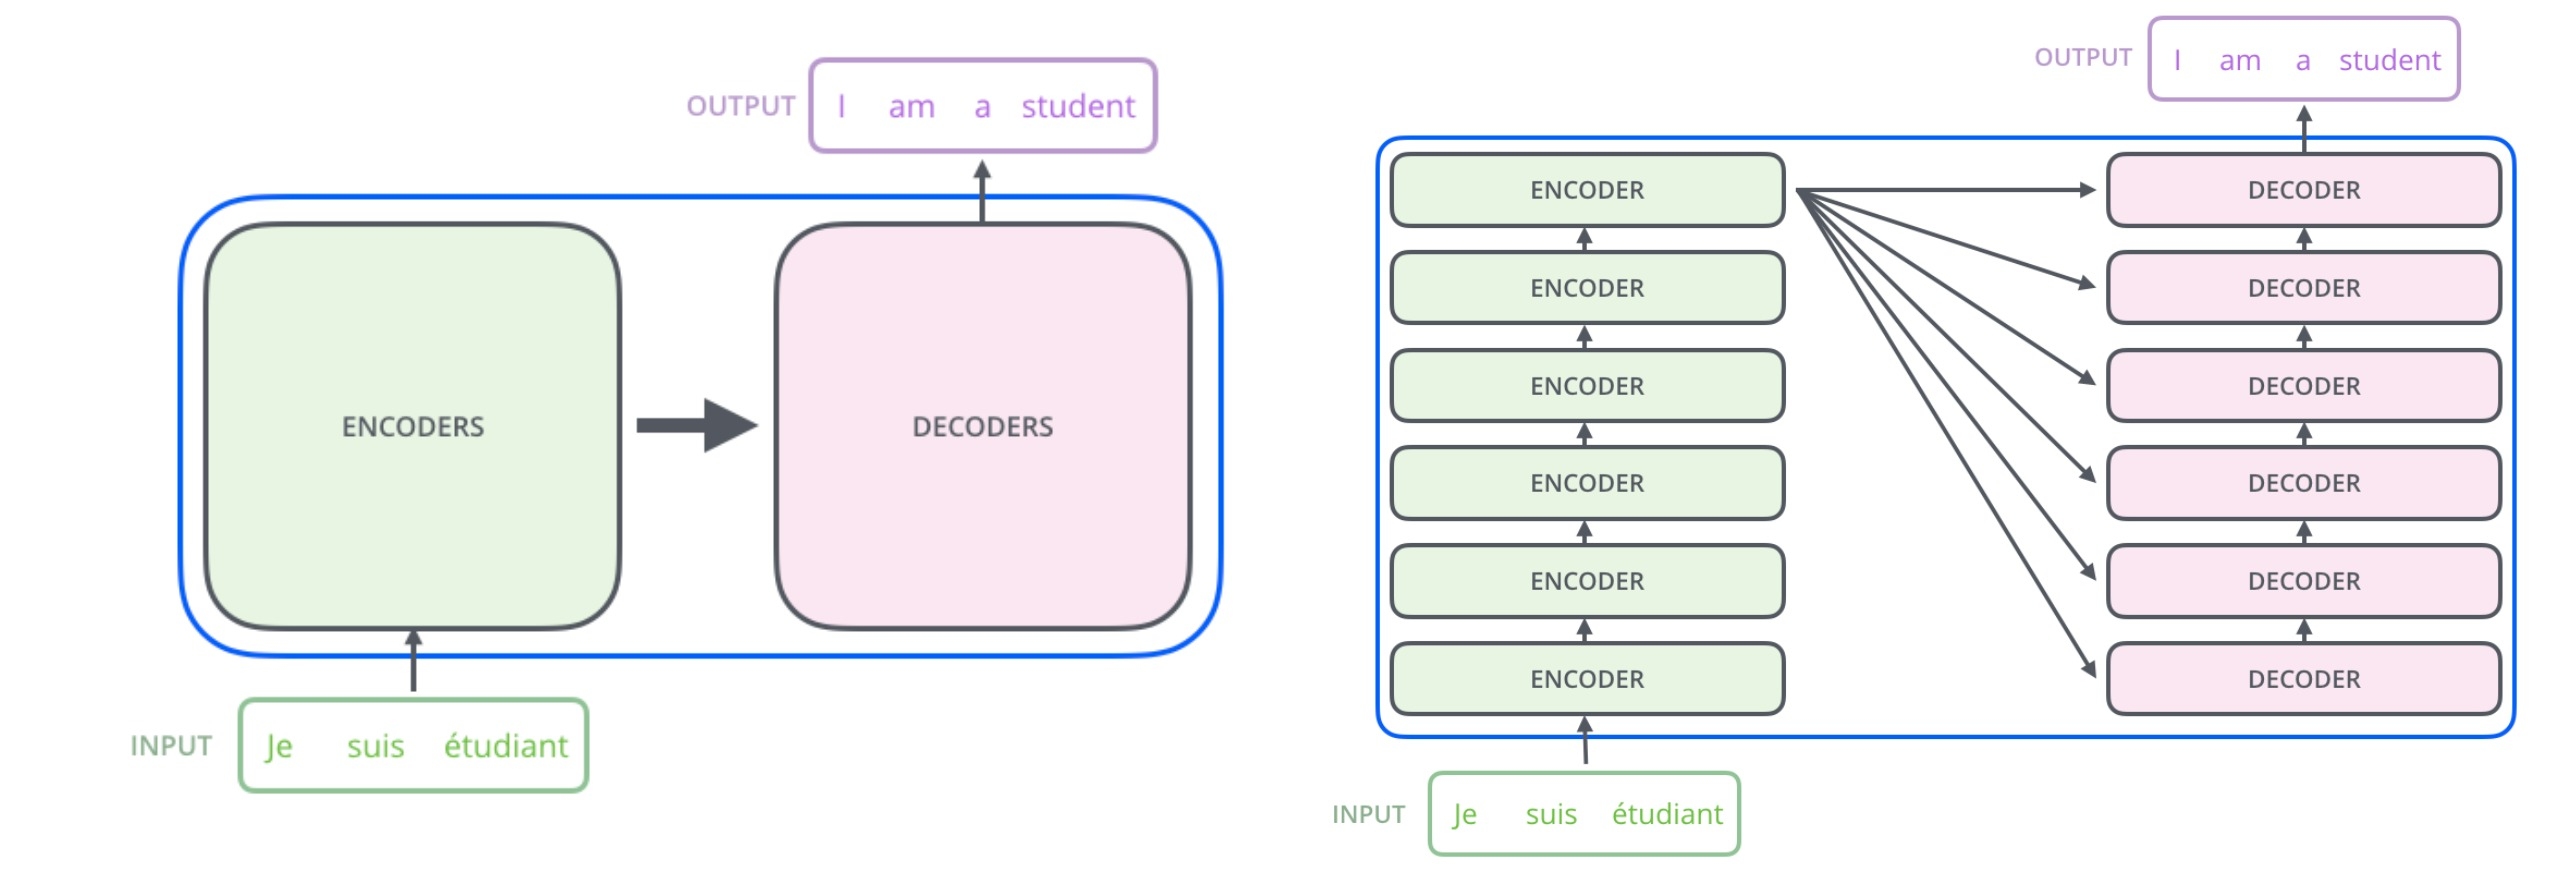

Все энкодеры идентичны по структуре, хотя и имеют разные веса. Каждый можно разделить на два подслоя.
- Входная последовательность, поступающая в энкодер, сначала проходит через слой внутреннего внимания (self-attention), помогающий энкодеру посмотреть на другие слова во входном предложении во время кодирования конкретного слова.
- Выход слоя внутреннего внимания отправляется в нейронную сеть прямого распространения (feed-forward neural network).

Декодер также содержит эти два слоя, но между ними есть слой внимания, который помогает декодеру фокусироваться на релевантных частях исходного предложения (аналогично механизму внимания в моделях seq2seq).


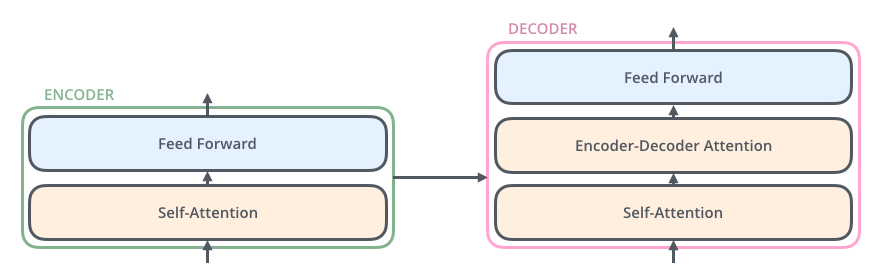

Как и в случае других алгоритмов, каждое слово входной и целевой последовательности преобразуется в вектор.

После того как слова входящего предложения преобразовались в эмбеддинги, каждый из них по отдельности проходит через слои энкодера. Одна из основных особенностей Трансформера состоит в том, что каждое слово идет по своей собственной траектории.

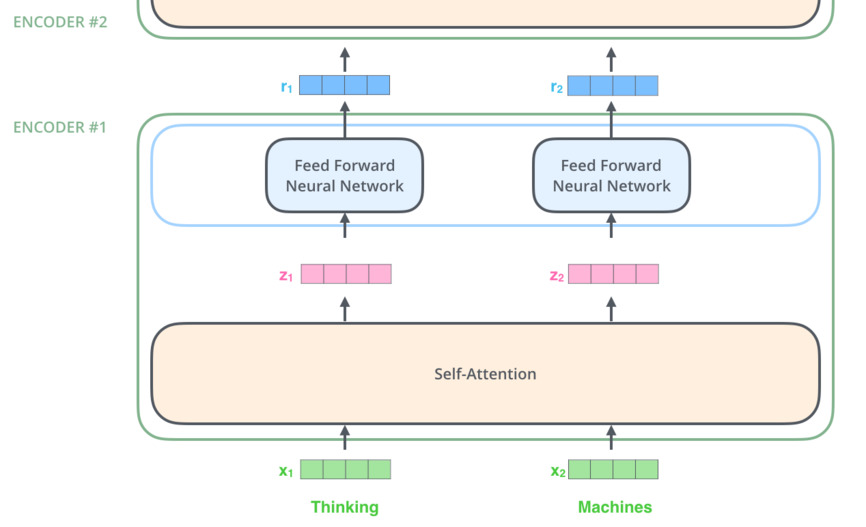

## Механизм внутреннего внимания

Пусть мы хотим перевести предложение: *The animal didn't cross the street because it was too tired*. Местоимение *it* может относиться к улице (*street*) или к животному (*animal*). Когда модель обрабатывает слово *it*, слой внутреннего внимания помогает понять, что *it* относится к *animal*.

По мере того как модель обрабатывает каждое слово входной последовательности, внутреннее внимание позволяет "взглянуть" на другие слова и лучше закодировать данное слово. Механизм внутреннего внимания – это метод, который Трансформер использует, чтобы смоделировать "понимание" других релевантных слов при обработке конкретного слова.

Во время кодирования *it* в энкодере №5 часть механизма внимания фокусируется на *The animal* и использует фрагмент его представления для кодирования *it*.

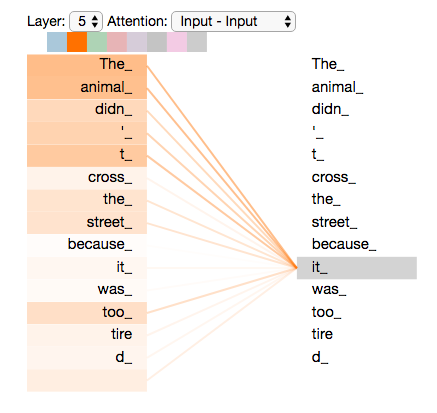

### На примере векторов

При вычислении внутреннего внимания используются: вектор запроса $query$, вектор ключа $key$ и вектор значения $value$. Они создаются с помощью умножения эмбеддинга слова последовательности на три матрицы весов (линейных слоя) $W^Q, W^K, W^V$. Размер новых векторов – 64, размер исходных векторов – 512.

$q_i=x_iW^Q$

$k_i=x_iW^K$

$v_i=x_iW^V$

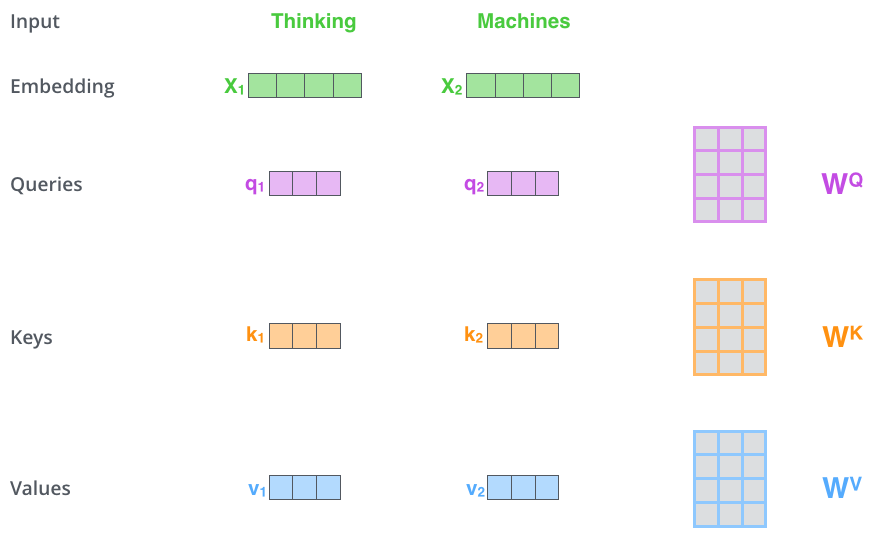

Далее вычисляется коэффициент внутреннего внимания $score$ для $i$-го слова по отношению к каждому слову в предложении. Коэффициент определяет, насколько нужно сфокусироваться на других частях предложения во время кодирования слова в $i$-й позиции. Коэффициент подсчитывается с помощью скалярного произведения вектора запроса $q$ $i$-го слова и вектора ключа $k$ каждого слова.

$score_{ij}=q_i \cdot k_j$

📌 Какие векторы нужно перемножить, чтобы посчитать коэффициент внимания слова *Thinking* по отношению к слову *Machines*? По отношению к самому себе?

На следующем шаге коэффициенты делятся на квадратный корень из $d_k$ – размера векторов ключа $k$. К получившимся значениям применяется функция активации softmax, чтобы коэффициенты в сумме давали 1. Полученный софтмакс-коэффициент определяет, в какой мере каждое из слов предложения "фокусируется" на другом слове.

$softmax.score_{ij}=softmax(\frac{score_i}{\sqrt d_k})$

После этого каждый вектор значения $v$ умножается на софтмакс-коэффициент, получаем взвешенные векторы. Идея в том, что нужно сохранять без изменений значения слов, на которых мы фокусируемся, и отвести на второй план нерелевантные слова (умножив их на небольшие значения, например, 0.001). Затем  взвешенные векторы складываются. Результат (взвешенная сумма) представляет собой выход слоя внутреннего внимания для $i$-го слова.

$sum_i=\sum_{j=1}^nv_j \cdot softmax.score_{ij}$

Полученный вектор передается дальше в нейронную сеть прямого распространения.

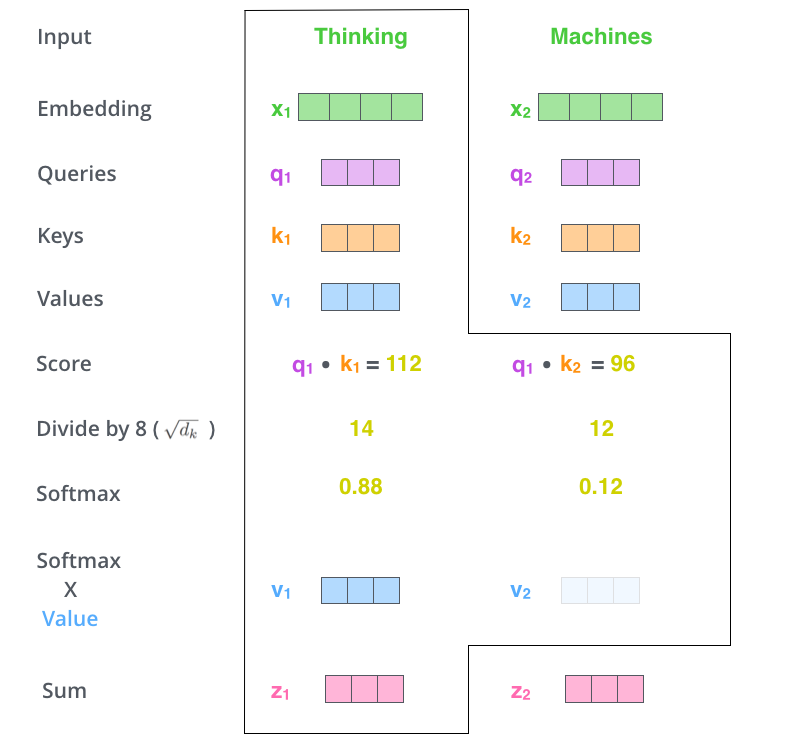

### На примере матриц

Аналогично, матрицы запроса $Q$, ключа $K$ и значения $V$ вычисляются с помощью умножения эмбеддингов матрицы $X$ на матрицы весов (линейные слои) $W^Q, W^K, W^V$. Каждая строка в матрице $X$ соответствует слову в предложении.

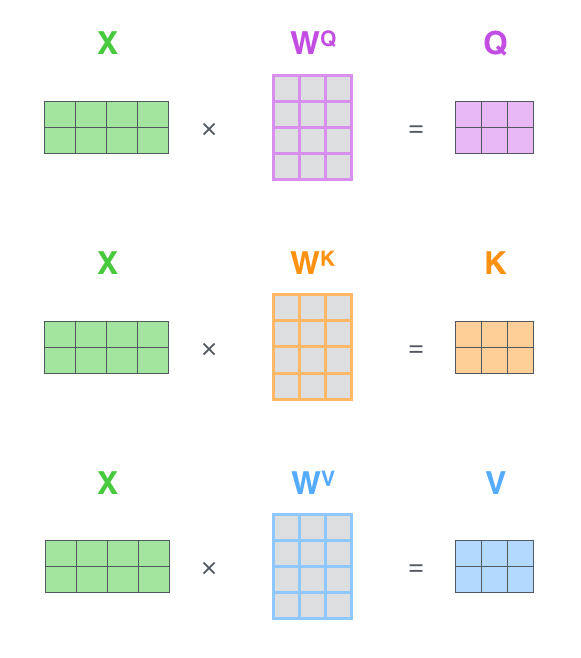

Последующие этапы для вычисления выхода слоя внутреннего внимания могут быть отражены в одной формуле.

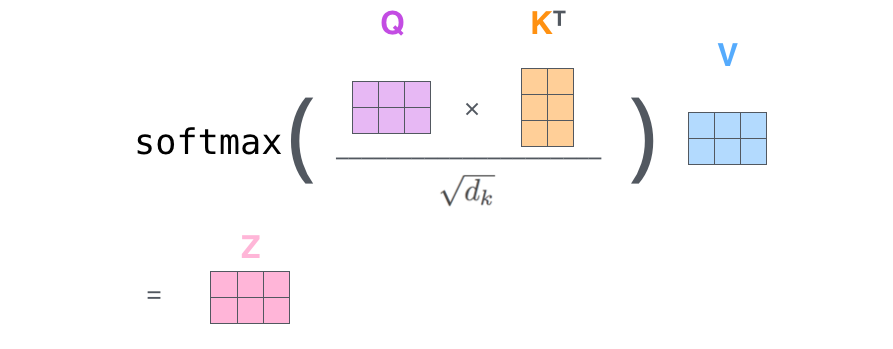

Напишем функцию `dot_product_attention` для подсчета внутреннего внимания.

$Attention(Q, K, V) = softmax\large(\frac{QK^T}{\sqrt{d_k}})V$

$Q, K, V$ — матрицы размера `batch_size, seq_length, num_features`.

Для умножения матриц по батчам используется метод `.bmm`.

Транспонирование осуществляется с помощью метода `.transpose`.

In [1]:
import torch

m1 = torch.randn(10, 3, 4)
m2 = torch.randn(10, 5, 4)
res = m1.bmm(m2.transpose(1,2))
res.size()

torch.Size([10, 3, 5])

In [2]:
import torch.nn.functional as f

def dot_product_attention(query, key, value):
    q_k_prod = query.bmm(key.transpose(1,2)) # Место для вашего кода
    d_root = key.size(-1) ** 0.5
    softmax = f.softmax(q_k_prod / d_root, dim=-1)
    attention = softmax.bmm(value) # Место для вашего кода
    return attention

## Множественное внимание

В Трансформере механизм внутреннего внимания совершенствуется с помощью добавления множественного внимания (multi-headed attention). Это повышает способность модели фокусироваться на разных словах. В случае множественного внимания мы располагаем отдельными матрицами весов $W^Q, W^K, W^V$  для каждой "головы", что в результате дает разные матрицы $Q, K, V$. Как и ранее, матрица $X$ умножается на веса $W^Q, W^K, W^V$ для получения матриц $Q, K, V$.

Трансформер использует 8 "голов" внимания, так что в итоге у нас получается 8 наборов для каждого энкодера и декодера. Сделав те же вычисления внутреннего внимания 8 раз с разными матрицами весов, в результате получим 8 разных матриц.

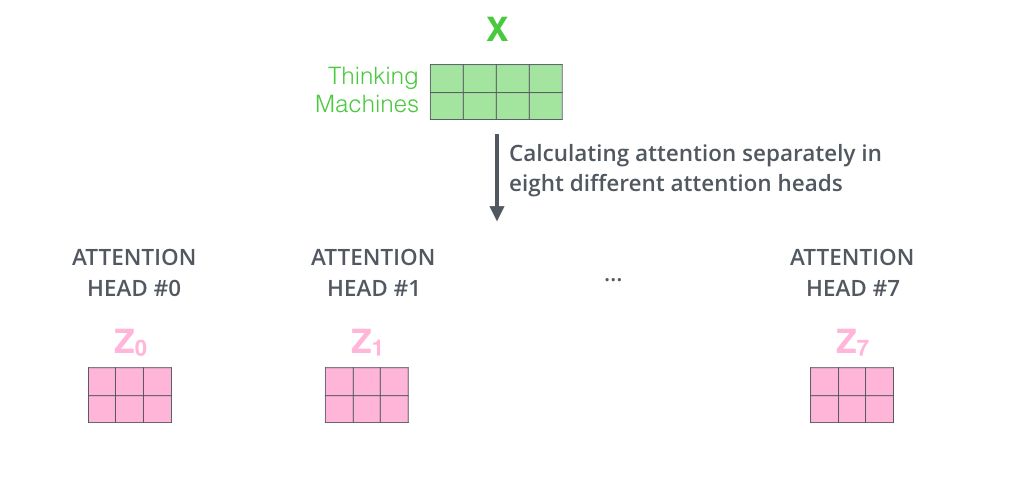

Однако слой сети прямого распространения не ожидает, что к нему поступит 8 матриц – он ждет всего одну, в которую нам и необходимо сжать полученные матрицы. Чтобы это сделать, можно конкатенировать и затем умножить их на дополнительные веса матрицы $W^O$.

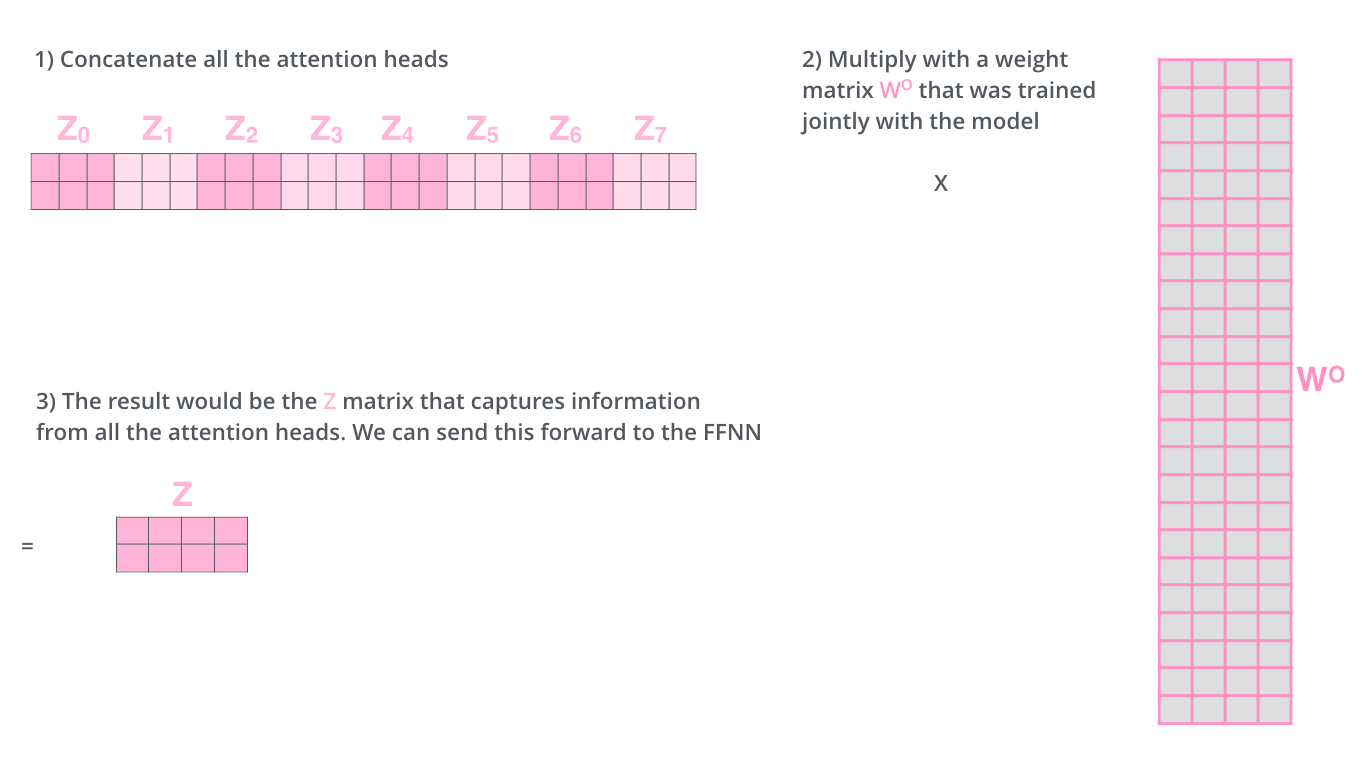

Мы можем отобразить все "головы" внимания на одной картинке.

📌 Какие головы больше фокусируются на каких словах?

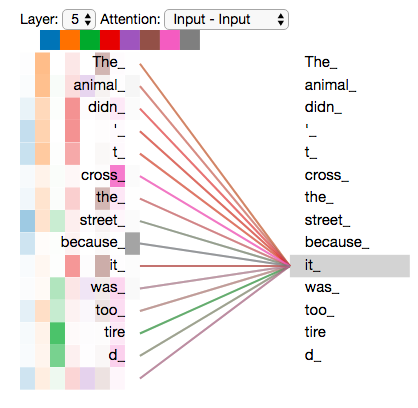

Реализация множественного внимания будет включать класс `AttentionHead` для создания одной "головы" внимания и класс `MultiHeadAttention` для создания множественного внимания.

Каждая голова внимания состоит из трех линейных слоев, через которые пропускаются матрицы $Q,K,V$, и скалярного произведения для вычисления внимания.

$head_i = Attention(Q W^Q_i, K W^K_i, V W^V_i)$

In [3]:
from torch import nn

class AttentionHead(nn.Module):
    def __init__(self, dim_in, dim_q):
        super().__init__()
        self.q = nn.Linear(dim_in, dim_q)
        self.k = nn.Linear(dim_in, dim_q)
        self.v = nn.Linear(dim_in, dim_q)

    def forward(self, query, key, value):
        dot_product = dot_product_attention(self.q(query), self.k(key), self.v(value)) # Место для вашего кода
        return dot_product

Для создание многоголового внимания необходим объединить нужное количество голов `num_heads` и выходной линейный слой `output`. Класс [nn.ModuleList](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html) объединяет объекты класса `nn.Module` в список.

Каждая голова внимания независимо вычисляет внимание (скалярное произведение) для своих матриц $Q,K,V$. Следовательно, каждая голова может "обращать внимание" на разные части предложения.

$MultiHead(Q, K, V) = Concat(head_1, ..., head_h)W^O$

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, dim_in, dim_q):
        super().__init__()
        self.heads = nn.ModuleList(
            [AttentionHead(dim_in, dim_q) for _ in range(num_heads)]
        )
        self.o = nn.Linear(num_heads * dim_q, dim_in)

    def forward(self, query, key, value):
        output = self.o(
            torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        )
        return output

## Кодирование позиции

Из-за того, что мы избавили от рекуррентной нейронной сети, информация о порядке слов перестала учитываться моделью. В классе `MultiHeadAttention` операции применяются к размерности 2 (признаки слов), но не к размерности 1 (слова последовательности).

Для того чтобы модель понимала порядок слов, вводятся векторы кодирования позиции (positional encoding). Они суммируются с векторами каждого слова.

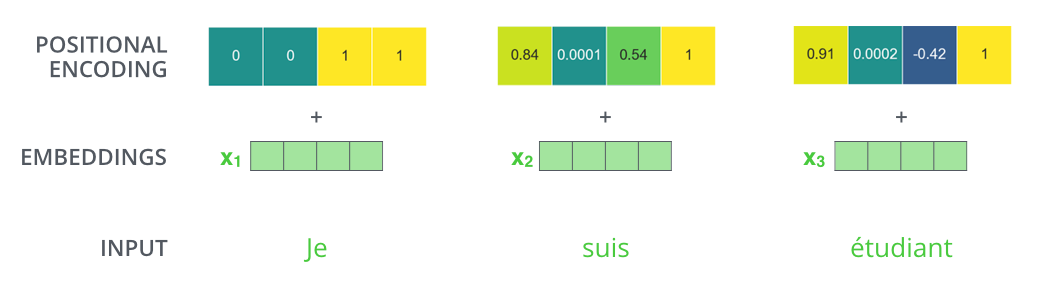

Информация о позиции кодируется с помощью тригонометрических функций: синуса и косинуса.

Пусть есть входная последовательность длины $L$, нужно закодировать позицию некоторого элемента $pos$.

$pos$ — индекс слова в исходной последовательности, $0 \leq pos < L$

$d$ — размер эмеддингов входного слоя

$i$ — номер координаты эмбеддинга входного слоя, $0 \leq i < \large \frac{d}{2}$

$p_0$ — первое слово последовательности, $d$ — длина вектора, $i$ — координаты вектора.

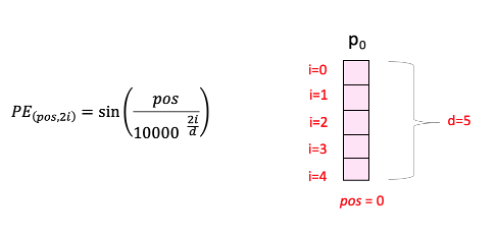

Слова с разным номером позиции будут иметь разные значения значения на оси $y$. Однако для некоторых позиций ($p_0$ и $p_6$) значения совпадают, поскольку синус — периодическая функция.

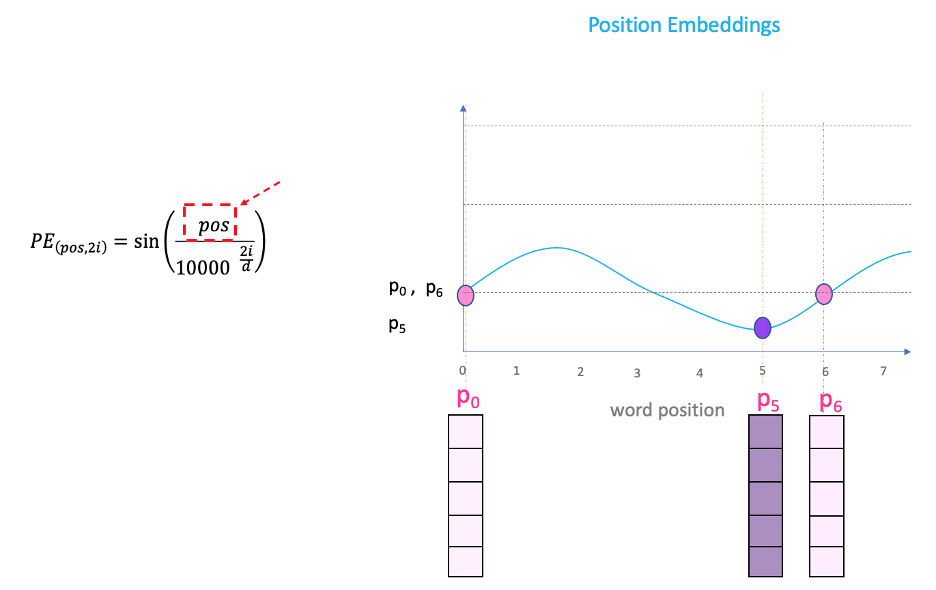

Получить разные значения можно благодаря параметру $i$. При изменении значения $i$ меняется частота, что приводит к получению разных значений для $p_0$ и $p_6$.

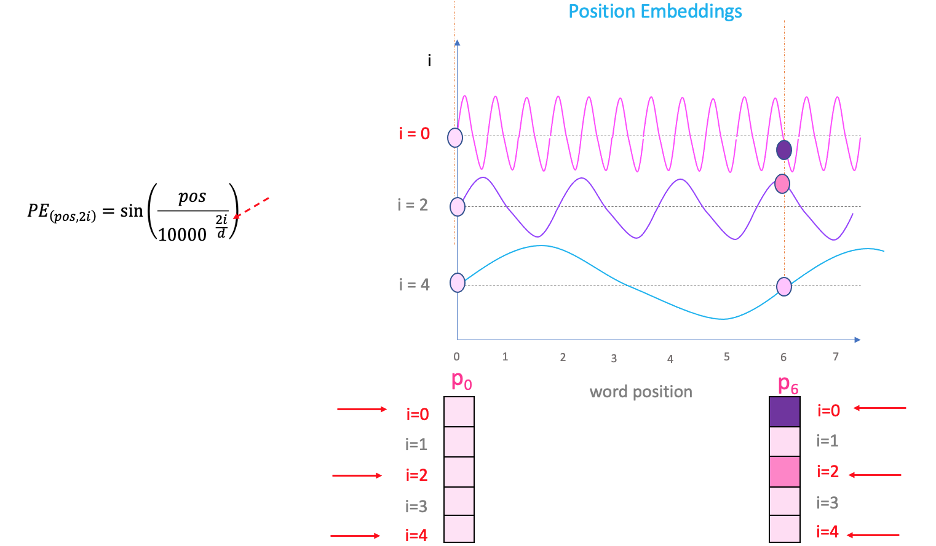

Напишем функцию `position_encoding` для кодирования позиции.

$PE_{(pos, 2i)}=sin(pos/10000^{2i/d_{model}})$

$PE_{(pos, 2i+1)}=cos(pos/10000^{2i/d_{model}})$

Для создания массива с индексами предложения используется метод `torch.arange`. Чтобы обозначить, что для четных координат (четные числа в векторе `dim`) применяется функция синуса `torch.sin`, а для нечетных (нечетные числа в векторе `dim`)— косинуса `torch.cos`, используется метод `torch.where`.

In [5]:
torch.arange(5), torch.arange(5).shape

(tensor([0, 1, 2, 3, 4]), torch.Size([5]))

In [6]:
x = torch.randn(3, 2)
y = torch.ones(3, 2)
x, y, torch.where(x > 0, x, y)

(tensor([[ 1.5783, -0.4260],
         [-1.3625,  0.8501],
         [ 0.9660,  0.2748]]),
 tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[1.5783, 1.0000],
         [1.0000, 0.8501],
         [0.9660, 0.2748]]))

In [7]:
def position_encoding(seq_len, dim_model):
    pos = torch.arange(seq_len).reshape(1, -1, 1)
    dim = torch.arange(dim_model).reshape(1, 1, -1)
    phase = pos / (1e4 ** (dim / dim_model))
    pe = torch.where(dim % 2 == 0, torch.sin(phase), torch.cos(phase)) # Место для вашего кода
    return pe

In [8]:
position_encoding(3, 4)

tensor([[[0.0000, 1.0000, 0.0000, 1.0000],
         [0.8415, 0.9950, 0.0100, 1.0000],
         [0.9093, 0.9801, 0.0200, 1.0000]]])

## Cеть прямого распространения

За слоем множественного внимания в энкодере и декодере следует сеть прямого распространения. Она состоит из двух линейных слоев и функции активации ReLU между ними. Размер входных и выходных данных — 512, промежуточный размер — 2048 (в 4 раза больше).

Класс [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) позволяет задать порядок следования слоев и функций активации.

In [16]:
def feed_forward(dim_input = 512, dim_feedforward = 2048):
    ffn = nn.Sequential(
        nn.Linear(dim_input, dim_feedforward),
        nn.ReLU(),
        nn.Linear(dim_feedforward, dim_input),
    )
    return ffn

## Остаточное соединение

Каждый подслой (внутреннее внимание, полносвязный) включает остаточное соединение (residual connection), за которым следует этап нормализации слоя ([layer normalization](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html)).

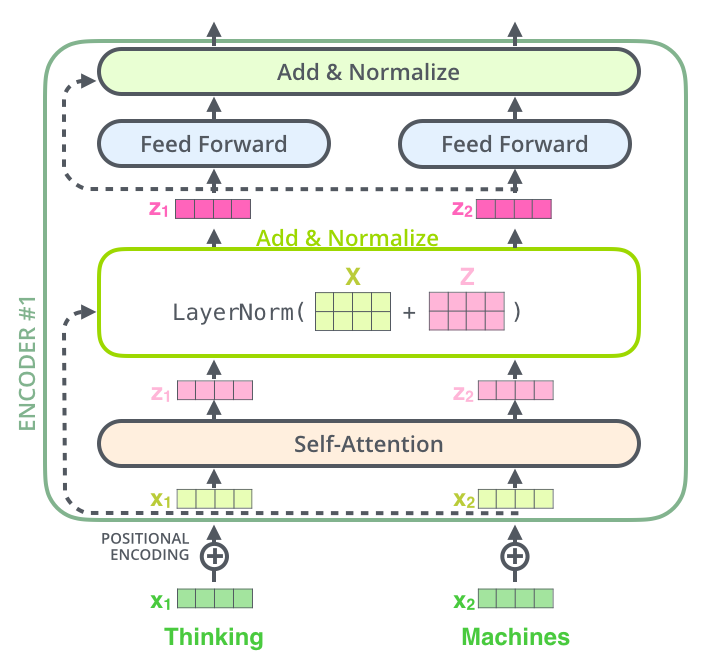

Эмбеддинг каждого элемента последовательности дублируется: одна копия поступает на вход слоя (внимания или сети прямого распространения), другая копия не меняется и прибавляется к выходу слоя. Это позволяет избежать затухания градиента.

После применяется нормализация. Веса могут принимать значения в разном диапазоне, но скорость обучение одинаковая. Из-за этого возникает сложность с обновлением весов.

Нормализация применяется по предложениям: применяется к первому признаку каждого слова в первом предложении, затем ко второму признаку каждого слова в первом предожении и т.д.

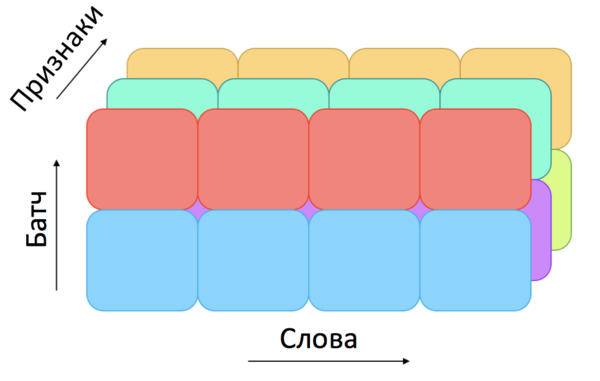

Среднее: $\mu_i =\frac{1}{m}\sum_{j=1}^mx_{ij}$

Стандартное отклонение: $\sigma_i = \frac{1}{m}\sum_{j=1}^m(x_{ij}-\mu_i)$

Нормализованное значение: $\hat x_{ij} = \frac {x_{ij}-\mu_i}{\sigma_i}$

Создадим класс `Residual` для остаточного соединения.

In [9]:
class Residual(nn.Module):
    def __init__(self, sublayer, dimension):
        super().__init__()
        self.sublayer = sublayer
        self.norm = nn.LayerNorm(dimension)

    def forward(self, *tensors):
        add_norm = self.norm(tensors[0] + self.sublayer(*tensors))
        return add_norm

## Энкодер

Можем перейти к реализации блока энкодера. Он состоит из класса `TransformerEncoderLayer` для одного слоя энкодера и класса `TransformerEncoder` для всего блока.

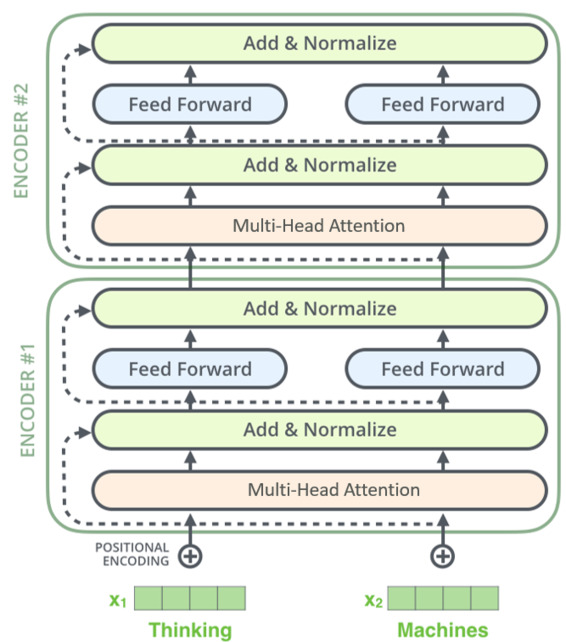

В классе `TransformerEncoderLayer` необходимо инициализировать слой внимания (множественное внимание, к которому применяется остаточное соединение) и полносвязный слой (сеть прямого распространения, к которой применяется остаточное соединение). Оба слоя по очереди применяются к набору исходных предложений `src`.

In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self,
                 dim_model = 512,
                 num_heads = 8,
                 dim_q = 64,
                 dim_feedforward = 2048):
        super().__init__()
        self.attention = Residual(
            # Место для вашего кода
            MultiHeadAttention(num_heads, dim_model, dim_q),
            dimension=dim_model
        )
        self.feed_forward = Residual(
            # Место для вашего кода
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model
        )

    def forward(self, src):
        src = self.attention(src, src, src)
        out = self.feed_forward(src)
        return out

В классе `TransformerEncoder` нужно создать список `nn.ModuleList` объектов класса `nn.Module`, каждый из которых относится к классу `TramsformerEncoderLayer` (аналогично классу `MultiHeadAttention`, состоящему из объектов класса `AttentionHead`).

In [11]:
class TransformerEncoder(nn.Module):
    def __init__(self,
        num_layers = 6,
        dim_model = 512,
        num_heads = 8,
        dim_q = 64,
        dim_feedforward = 2048
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                # Место для вашего кода
                TransformerEncoderLayer(dim_model, num_heads, dim_q, dim_feedforward) for _ in range(num_layers)
            ]
        )

    def forward(self, src):
        seq_len, dimension = src.size(1), src.size(2) # длина последовательности, размер эмбеддинга
        src += position_encoding(seq_len, dimension) # применяется функция для кодирования позиции
        for layer in self.layers:
            src = layer(src)

        return src

## Декодер

Блок декодера устроен очень похоже, но есть несколько отличий.
- Декодер принимает два аргумента: целевое предложение `target` и выход энкодера `memory`.
- Используется два слоя множественного внимания
  - маскированное множественное внимания для обработки целевого предложения
  - множественное внимание между энкодером и декодером для сравнения целевого и исходного предложения
- Второй слой принимает в качестве матриц $K$ и $V$ использует выход энкодера `memory`.

Декодер выполняет задачу языкового моделирования и предсказывает вероятность следующего слова. Следовательно, при обработке целевой последовательности он не может "заглядывать" вперед и анализировать контекст, который еще не был сгенерирован. Поэтому используется маскирование всех позиций после текущей, их векторы заполняются значениями `-inf`.


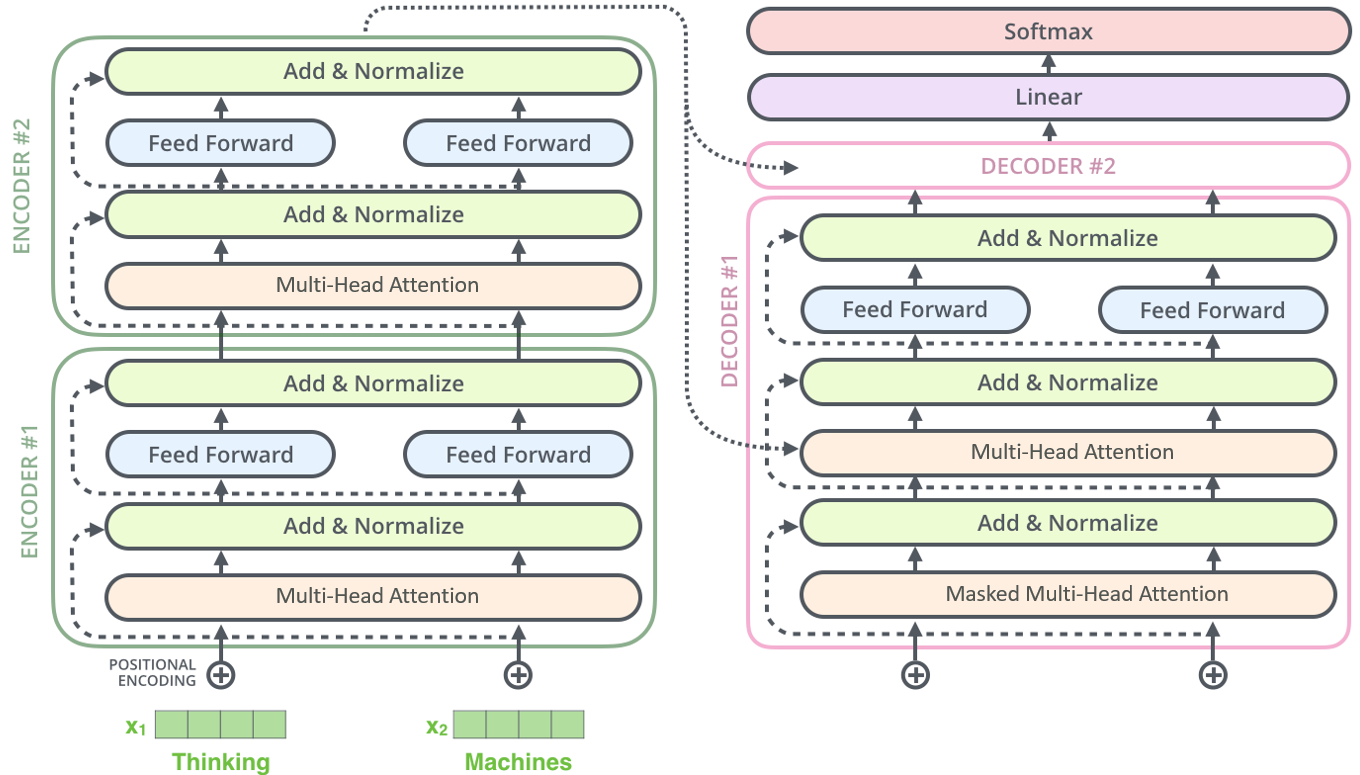

Аналогично, создадим класс `TransformerDecoderLayer` для одного слоя декодера и класс `TransformerDecoder` для всего блока.

Класс `TransformerDecoderLayer` содержит три слоя: маскированное множественное внимание, множественное внимание энкодера-декодера и сеть прямого распросранения. При прямом проходе все эти слои применяются последовательно. На вход первого слоя внимания поступает набор целевых предложений (в трех копиях), на вход второго — целевые предложения и выход энкодера (в двух копиях), на вход третьего — выход второго слоя внимания.

In [12]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self,
                 dim_model = 512,
                 num_heads = 8,
                 dim_q = 64,
                 dim_feedforward = 2048):
        super().__init__()
        self.attention_1 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q),
            dimension=dim_model
        )
        self.attention_2 = Residual(
            MultiHeadAttention(num_heads, dim_model, dim_q),
            dimension=dim_model
        )
        self.feed_forward = Residual(
            feed_forward(dim_model, dim_feedforward),
            dimension=dim_model
        )

    def forward(self, tgt, memory):
        tgt = self.attention_1(tgt, tgt, tgt) # Место для вашего кода
        tgt = self.attention_2(tgt, memory, memory) # Место для вашего кода
        tgt = self.feed_forward(tgt) # Место для вашего кода
        return tgt

В классе `TransformerDecoder` создается список `nn.ModuleList` объектов класса `nn.Module`, каждый из которых относится к классу `TramsformerDecoderLayer`. После слоев декодера применяется линейный слой и softmax, что позволяет получить распределение вероятностей для каждого слова.

In [13]:
class TransformerDecoder(nn.Module):
    def __init__(
        self,
        num_layers = 6,
        dim_model = 512,
        num_heads = 8,
        dim_q = 64,
        dim_feedforward = 2048
    ):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerDecoderLayer(dim_model, num_heads, dim_q, dim_feedforward)
                for _ in range(num_layers)
            ]
        )
        self.linear = nn.Linear(dim_model, dim_model)

    def forward(self, tgt, memory):
        seq_len, dimension = tgt.size(1), tgt.size(2)
        tgt += position_encoding(seq_len, dimension)
        for layer in self.layers:
            tgt = layer(tgt, memory)
        out = torch.softmax(self.linear(tgt), dim=-1)

        return out

## Трансформер

Блоки энкодера и декодера объединяются в классе `Transformer`.

In [14]:
class Transformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers = 6,
        num_decoder_layers = 6,
        dim_model = 512,
        num_heads = 8,
        dim_feedforward = 2048,
        activation = nn.ReLU(),
    ):
        super().__init__()
        self.encoder = TransformerEncoder(
            num_layers=num_encoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward
        )
        self.decoder = TransformerDecoder(
            num_layers=num_decoder_layers,
            dim_model=dim_model,
            num_heads=num_heads,
            dim_feedforward=dim_feedforward
        )

    def forward(self, src, tgt):
        result = self.decoder(tgt, self.encoder(src))
        return result

Попробуем применить модель для прямого прохода по случайно сгенерированным данным.

In [17]:
src = torch.rand(8, 32, 512)
tgt = torch.rand(8, 16, 512)
model = Transformer()
out = model(src, tgt)
print(out.shape)

torch.Size([8, 16, 512])
